In [2]:
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
df = pd.read_csv(config.DATA)
df = df.rename(columns={ "TARGET(PRICE_IN_LACS)": "PRICE"})

# Initial exploration
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Check for missing values
missing_data = df.isnull().sum()
print("Missing values:\n", missing_data[missing_data > 0])

# Handle missing values (example strategies):
# For numerical columns: fill with median
# For categorical columns: fill with mode or create 'Unknown' category
df.fillna(df.median(numeric_only=True), inplace=True)

# Remove or cap extreme outliers if necessary
# Example: Remove houses with price > 99th percentile
price_99th = df['PRICE'].quantile(0.99)
df = df[df['PRICE'] <= price_99th]

  POSTED_BY  UNDER_CONSTRUCTION  RERA  BHK_NO. BHK_OR_RK    SQUARE_FT  \
0     Owner                   0     0        2       BHK  1300.236407   
1    Dealer                   0     0        2       BHK  1275.000000   
2     Owner                   0     0        2       BHK   933.159722   
3     Owner                   0     1        2       BHK   929.921143   
4    Dealer                   1     0        2       BHK   999.009247   

   READY_TO_MOVE  RESALE                      ADDRESS  LONGITUDE   LATITUDE  \
0              1       1        Ksfc Layout,Bangalore  12.969910  77.597960   
1              1       1    Vishweshwara Nagar,Mysore  12.274538  76.644605   
2              1       1             Jigani,Bangalore  12.778033  77.632191   
3              1       1  Sector-1 Vaishali,Ghaziabad  28.642300  77.344500   
4              0       1             New Town,Kolkata  22.592200  88.484911   

   PRICE  
0   55.0  
1   51.0  
2   43.0  
3   62.5  
4   60.5  
<class 'pandas.core.

In [3]:
# Stop the current cell and run this instead
print("Dataset shape:", df.shape)
print("\nCategorical columns and their unique values:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset shape: (29156, 12)

Categorical columns and their unique values:
POSTED_BY: 3 unique values
BHK_OR_RK: 2 unique values
ADDRESS: 6859 unique values


Numerical features: ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'LONGITUDE', 'LATITUDE']
Categorical features: ['POSTED_BY', 'BHK_OR_RK', 'ADDRESS']
Original shape: (29156, 12)
After processing: (29156, 12)


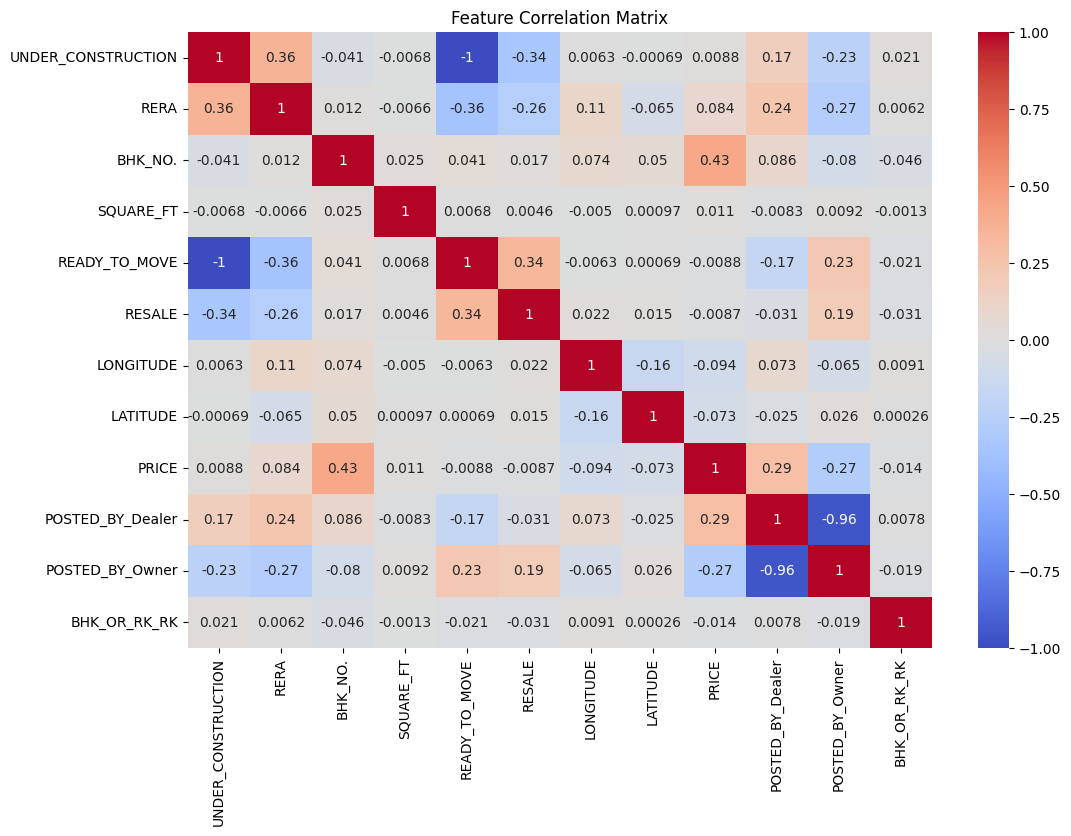

In [5]:
# Step 3: Feature Selection and Engineering (FIXED VERSION)

# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from features
if 'PRICE' in numerical_features:  # Adjust column name as needed
    numerical_features.remove('PRICE')

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Handle categorical variables intelligently
# Only encode low-cardinality categorical features
low_cardinality_cats = ['POSTED_BY', 'BHK_OR_RK']  # These have 3 and 2 values

# DROP the ADDRESS column (too many unique values)
df_processed = df.drop('ADDRESS', axis=1)

# One-hot encode only the manageable categorical features
df_encoded = pd.get_dummies(df_processed, columns=low_cardinality_cats, drop_first=True)

print(f"Original shape: {df.shape}")
print(f"After processing: {df_encoded.shape}")

# Now do correlation analysis (this will be much faster)
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()


In [6]:
# Separate features and target
X = df_encoded.drop('PRICE', axis=1)
y = df_encoded['PRICE']

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (23324, 11)
Test set size: (5832, 11)


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialise teh scaler
scaler = StandardScaler()

# Fit on training data and trasnform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Before scaling:")
print("X_train mean:", X_train.mean().round(2))
print("X_train std:", X_train.std().round(2))

print("After scaling:")
print("X_train_scaled mean:", X_train_scaled.mean(axis=0).round(2))
print("X_train_scaled std:", X_train_scaled.std(axis=0).round(2))

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Before scaling:
X_train mean: UNDER_CONSTRUCTION       0.18
RERA                     0.32
BHK_NO.                  2.38
SQUARE_FT             1444.67
READY_TO_MOVE            0.82
RESALE                   0.93
LONGITUDE               21.33
LATITUDE                76.83
POSTED_BY_Dealer         0.62
POSTED_BY_Owner          0.36
BHK_OR_RK_RK             0.00
dtype: float64
X_train std: UNDER_CONSTRUCTION       0.38
RERA                     0.47
BHK_NO.                  0.86
SQUARE_FT             8855.58
READY_TO_MOVE            0.38
RESALE                   0.25
LONGITUDE                6.23
LATITUDE                10.62
POSTED_BY_Dealer         0.49
POSTED_BY_Owner          0.48
BHK_OR_RK_RK             0.03
dtype: float64
After scaling:
X_train_scaled mean: [-0.  0. -0. -0. -0.  0.  0. -0.  0.  0. -0.]
X_train_scaled std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Scaled training set shape: (23324, 11)
Scaled test set shape: (5832, 11)


Testing different k values...
k=5: CV MSE = 3,468
k=10: CV MSE = 3,661
k=15: CV MSE = 3,791
k=20: CV MSE = 3,897
k=25: CV MSE = 4,018
k=30: CV MSE = 4,116


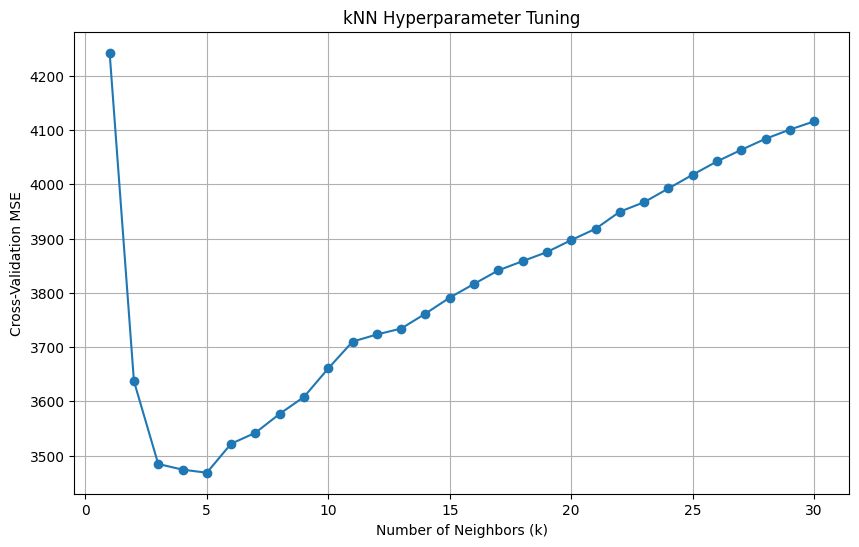

Optimal k: 5
Best CV MSE: 3,468


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

# Test different values of k
k_values = range(1, 31)
cv_scores = []

print("Testing different k values...")
for k in k_values:
  knn = KNeighborsRegressor(n_neighbors=k)
  scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
  cv_scores.append(-scores.mean())
  if k % 5 == 0:
    print(f"k={k}: CV MSE = {cv_scores[-1]:,.0f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation MSE')
plt.title('kNN Hyperparameter Tuning')
plt.grid(True)
plt.show()

# Find optimal k
optimal_k = k_values[np.argmin(cv_scores)]
print(f"Optimal k: {optimal_k}")
print(f"Best CV MSE: {min(cv_scores):,.0f}")

Test Set Performance:
Mean Squared Error: 3,820.01
Root Mean Squared Error: 61.81
R2 Score: 0.6805
Average prediction error: 61.8 lakhs
Model explains 68.0% of price variation


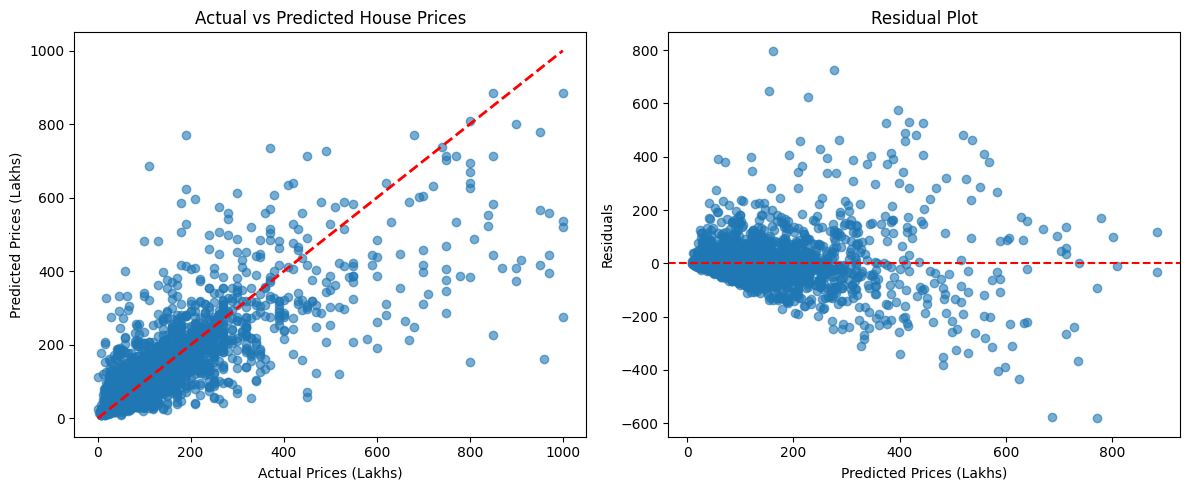


Sample Predictions:
Actual: 16.5 lakhs, Predicted: 42.3 lakhs, Error: 25.8 lakhs
Actual: 43.0 lakhs, Predicted: 185.6 lakhs, Error: 142.6 lakhs
Actual: 61.0 lakhs, Predicted: 74.9 lakhs, Error: 13.9 lakhs
Actual: 25.0 lakhs, Predicted: 34.4 lakhs, Error: 9.4 lakhs
Actual: 36.0 lakhs, Predicted: 35.9 lakhs, Error: 0.1 lakhs


In [14]:
# Final model training
final_knn = KNeighborsRegressor(n_neighbors=5)
final_knn.fit(X_train_scaled, y_train)

# Model evaluation
y_pred = final_knn.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance:")
print(f"Mean Squared Error: {mse:,.2f}")
print(f"Root Mean Squared Error: {rmse:,.2f}")
print(f"R2 Score: {r2:.4f}")

print(f"Average prediction error: {rmse:.1f} lakhs")
print(f"Model explains {r2*100:,.1f}% of price variation")

# Visualisation
plt.figure(figsize=(12,5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices (Lakhs)')
plt.ylabel('Predicted Prices (Lakhs)')
plt.title('Actual vs Predicted House Prices')

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices (Lakhs)')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

# Show some example predictions
print(f"\nSample Predictions:")
sample_indices = np.random.choice(len(y_test), 5, replace=False)
for i in sample_indices:
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    error = abs(actual - predicted)
    print(f"Actual: {actual:.1f} lakhs, Predicted: {predicted:.1f} lakhs, Error: {error:.1f} lakhs")